# Searching for Limit Cycles via Trajectory Optimization

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/underactuated.html?chapter=drake).

In [0]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

In [0]:
# others
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq)

from underactuated import FindResource

#Importing the URDF file for The Kneed Walker


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [64]:
downloaded = drive.CreateFile({'id':'12uxHHOS9cgRSxI0SBKku0-qLoXOAHE-x'}) # replace the id with id of file you want to access
downloaded.GetContentFile('kneed_compass_gait.urdf') 

KeyboardInterrupt: ignored

In [0]:
downloaded = drive.CreateFile({'id':'1ViJ1_3a1ziq6wBPLt0fmOqfnuZd8-rV_'}) # replace the id with id of file you want to access
downloaded.GetContentFile('compass_gait.urdf') 

In [0]:
import pandas as pd
xyz = pd.read_csv('kneed_compass_gait.urdf') 
print(xyz.head(1))

#Problem Description

For the kneed Walker the constraints are given by Vaanessas Thesis (p. 26). Where q3 is used is measured in absolute distance from the vertical axis, we can express q3 as: q3 = q2 + theta3

## Parse the `urdf` and Get the `MultibodyPlant`

We start by defining a couple of physical parameters that we will need below.

In [0]:
# friction coefficient between feet and ground
friction = .2

# position of the feet in the respective leg frame
# (must match the urdf)
foot_in_leg = {
    'stance_leg': np.zeros(3),        # stance foot in stance-leg frame
    'swing_leg': np.array([0, 0, -1]) # swing foot in swing-leg frame
}

In [0]:
# parse urdf and create the MultibodyPlant
kneed_compass_gait = MultibodyPlant(time_step=0)
#file_name = FindResource('kneed_compass_gait.urdf')
file_name = 'kneed_compass_gait.urdf'
#file_name = FindResource('compass_gait.urdf')
#file_name = 'compass_gait.urdf'
Parser(kneed_compass_gait).AddModelFromFile(file_name)
kneed_compass_gait.Finalize()

# overwrite MultibodyPlant with its autodiff copy
kneed_compass_gait = kneed_compass_gait.ToAutoDiffXd()

# number of configuration variables
nq = kneed_compass_gait.num_positions()

# number of components of the contact forces
nf = 2

## Helper Functions for the `MathematicalProgram`

When writing a `MathematicalProgram` in Drake, optimization variables are `symbolic.Variable` objects.
These cannot be passed directly to the `MultibodyPlant` functions (such as `CalcMassMatrix`), which only accept floats or `AutoDiffXd` types.
Hence, if you need to add a constraint which involves the evaluation of a `MultibodyPlant` function, you need to proceed as follows.

Write a python function (say `my_fun`) that, given the numeric value (`float` or `AutoDiffXd`) of certain variables in the problem, returns the numeric value of the quantity that you want to constrain.
Let `vars` be the arguments of this function and `values` its output (both can be arrays).
Using the method `MathematicalProgram.AddConstraint` you can write `prog.AddConstraint(my_fun, lb=values_lb, ub=values_ub, vars=vars)` to enforce the constraints `values_lb <= values <= values_ub`, where `value_lb` and `value_ub` are vectors of floats of appropriate dimensions.
Then, at solution time, the solver will evaluate `my_fun` passing autodiff variables, retrieving in this way the numeric values of the constraint violations and their derivatives.

In the following cell we wrote the functions that we will need to enforce the necessary constraints in the trajectory optimization problem.

In [0]:
# Function that given the current configuration, velocity,
# acceleration, and contact force at the stance foot, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nq + nf
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, f = np.split(vars, split_at)
    
    # set compass gait state
    context = kneed_compass_gait.CreateDefaultContext()
    kneed_compass_gait.SetPositions(context, q)
    kneed_compass_gait.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = kneed_compass_gait.CalcMassMatrixViaInverseDynamics(context)
    Cv = kneed_compass_gait.CalcBiasTerm(context)
    tauG = kneed_compass_gait.CalcGravityGeneralizedForces(context)
    
    # Jacobian of the stance foot
    J = get_foot_jacobian(kneed_compass_gait, context, 'stance_leg')
    

    ### The actuators should be added here somewhere

    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - J.T.dot(f)

# Function that given the current configuration, returns
# the distance of the swing foot from the ground (scalar).
# We have penetration if the function output is negative.
def swing_foot_height(q):
    
    # get reference frames for the swing leg and the ground
    leg_frame = kneed_compass_gait.GetBodyByName('swing_leg').body_frame()
    ground_frame = kneed_compass_gait.GetBodyByName('ground').body_frame()
    
    # position of the swing foot in ground coordinates
    context = kneed_compass_gait.CreateDefaultContext()
    kneed_compass_gait.SetPositions(context, q)
    swing_foot_position = kneed_compass_gait.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg['swing_leg'],
        ground_frame
    )
    
    # return only the coordinate z
    # (distance normal to the ground)
    return swing_foot_position[-1]

# Function that implements the impulsive collision derived in
# the textbook appendix. Arguments are: compass gait configuration,
# velocities before and after heel strike, and the swing-foot
# impulse (in latex, $\int_{t_c^-}^{t_c^+} \lambda dt$).
# Returns a vector of quantities that must vanish in order
# for the impulsive dynamics to be verified: it enforces the velocity
# jump due to the impulse, and the inelastic behavior of the
# collision (zero coefficient of restitution $e$).
# See http://underactuated.mit.edu/multibody.html#impulsive_collision
def reset_velocity_heelstrike(vars):
    
    # split input vector in subvariables
    # qd_pre: generalized velocity before the heel strike
    # qd_post: generalized velocity after the heel strike
    # imp: swing-foot collision impulse (2d vector)
    assert vars.size == 3 * nq + nf
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd_pre, qd_post, imp = np.split(vars, split_at)

    # set compass gait configuration
    context = kneed_compass_gait.CreateDefaultContext()
    kneed_compass_gait.SetPositions(context, q)
    
    # get necessary matrices
    M = kneed_compass_gait.CalcMassMatrixViaInverseDynamics(context)
    J = get_foot_jacobian(kneed_compass_gait, context, 'swing_leg')
    
    # return a vector that must vanish for the impulsive dynamics to hold
    return np.concatenate((
        M.dot(qd_post - qd_pre) - J.T.dot(imp), # velocity jump due to the impulse
        J.dot(qd_post)                          # zero velocity restitution
    ))

# Function that given a leg, returns the Jacobian matrix for the related foot.
def get_foot_jacobian(compass_gait, context, leg):
    
    # get reference frames for the given leg and the ground
    leg_frame = kneed_compass_gait.GetBodyByName(leg).body_frame()
    ground_frame = kneed_compass_gait.GetBodyByName('ground').body_frame()

    # compute Jacobian matrix
    J = kneed_compass_gait.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        leg_frame,
        foot_in_leg[leg],
        ground_frame,
        ground_frame
    )
    
    # discard y components since we are in 2D
    return J[[0, 2]]

## The Trajectory Optimization Problem

We start by setting some parameters of our optimization problem.

In [0]:
# time steps in the trajectory optimization
T = 50

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

#v_desired = 0.5

**Troubleshooting.**
To simplify the reading, we divide the construction of the `MathematicalProgram` in multiple cells.
If you modify any of the components of the problem, be sure to rerun your code starting from the following cell (where the `MathematicalProgram` is initialized).
Otherwise you will add the same constraints multiple times to the same optimization problem.

We start from the decision variables of the trajectory optimization problem.
Notice that we also add the accelerations `qdd` among the optimization variables here.
This is slightly unusual, and not necessary, but in these circumstances it simplifies a bit the code.

In [0]:
# initialize program
prog = MathematicalProgram()

# vector of the time intervals
# (distances between the T + 1 break points)
h = prog.NewContinuousVariables(T, name='h')

# system configuration, generalized velocities, and accelerations
q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

# stance-foot force
f = prog.NewContinuousVariables(rows=T, cols=nf, name='f')

# heel strike impulse for the swing leg
imp = prog.NewContinuousVariables(nf, name='imp')

# generalized velocity after the heel strike
# (if "mirrored", this velocity must coincide with the
# initial velocity qd[0] to ensure periodicity)
qd_post = prog.NewContinuousVariables(nq, name='qd_post')

In [0]:
# The length of the stride is decision variable. This is necessary because we will have constraints on the velocity
stride_length = prog.NewContinuousVariables(1, name='stride_length')

Here are part of the constraints of the optimization problem.

In [119]:
# lower and upper bound on the time steps for all t
prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

# link the configurations, velocities, and accelerations
# uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
### Constraints for propagation of the system
for t in range(T):
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

# manipulator equations for all t (implicit Euler)
### Ensures that the system is calculated correctly
for t in range(T):
    vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t]))
    prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=vars)
    
# velocity reset across heel strike
# see http://underactuated.mit.edu/multibody.html#impulsive_collision
vars = np.concatenate((q[-1], qd[-1], qd_post, imp))
prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nq+nf), ub=[0]*(nq+nf), vars=vars)
    
# mirror initial and final configuration
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(eq(q[0], - q[-1]))

# mirror constraint between initial and final velocity
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(qd[0, 0] == 0)
prog.AddLinearConstraint(qd[0, 1] == 0)
prog.AddLinearConstraint(qd[0, 2] == qd_post[2] + qd_post[3])
prog.AddLinearConstraint(qd[0, 3] == - qd_post[3])

Now it is your turn to complete the optimization problem.
You need to add five groups of constraints:
1. **Stance foot on the ground for all times.**
This `LinearConstraint` must ensure that $x(t) = y(t) = 0$ for all $t$.
2. **Swing foot on the ground at time zero.**
This constraint must ensure that the initial configuration $\mathbf{q}(0)$ is such that the swing foot is on the ground.
For a more complex robot, this would be a tough nonlinear constraint.
For the compass gait, knowing that the stance foot is on the ground, you should be able to express this as a `LinearConstraint` on the entries of $\mathbf{q}(0)$.
3. **No penetration of the swing foot in the ground for all times.**
This nonlinear constraint can be added using the function `swing_foot_height` we defined above.
Follow the examples from the previous cell to see how to add a nonlinear constraint defined via a python function using `AddConstraint`.
Note that, in this case, you want the upper bound on the function output to be `ub=[np.inf]` for all times.
4. **Stance-foot contact force in friction cone for all times.**
To prevent the robot from slipping, the contact force `f[t]` must lie in the friction cone for all `t`.
This means that the normal component `f[t, 1]` must be nonnegative, and the tangential component `f[t, 0]` must be, in absolute value, lower or equal than the normal component `f[t, 1]` times the friction coefficient (`friction` here).
Note that these conditions can be enforced as three `LinearConstraint`s per time step `t`.
5. **Swing-foot impulse in friction cone.**
To ensure that the swing foot is completely stopped by the heel strike, ensure that the impulse `imp` belongs to the friction cone.
This can be done using `AddLinearConstraint` three times, as for the previous bullet point.

**Troubleshooting:**
Unfortunately, nonlinear solvers are very sensitive.
It can happen that, just changing the order in which you add constraints to the problem, you get a different solution.
We suggest you to add these constraints in the given order: for us it worked fine.

In [120]:
# 1. stance foot on the ground for all times
# modify here
z = np.array([0])

for t in range(T):
  prog.AddLinearConstraint(eq(q[t][0], z))
  prog.AddLinearConstraint(eq(q[t][1], z))

# 2. swing foot on the ground at time zero
# modify here
#print(q.shape)

prog.AddLinearConstraint(q[0, 2] == -q[0, 3]/2)

prog.AddLinearConstraint(q[0, 4] == z)
prog.AddLinearConstraint(qd[0, 4] == z)

prog.AddLinearConstraint(q[-1, 4] == z)
prog.AddLinearConstraint(qd[-1, 4] == z)
#prog.AddLinearConstraint(qdd[-1, 4] == z)

# 3. no penetration of the swing foot in the ground for all times
# modify here
#swing_foot_height(q) returns z coordinate of swingfoot

#####for t in range(T):
#####    vars = q[t]
#####    prog.AddConstraint(swing_foot_height, lb=[0], ub=[np.inf], vars=vars)

# 4. stance-foot contact force in friction cone for all times
# modify here

# 5. swing-foot impulse in friction cone
# modify here

Here we set the initial guess for our optimization problem.

For the time steps `h` we just initialize them to their maximal value `h_max` (somewhat an arbitrary decision, but it works).

For the robot configuration `q`, we interpolate between the initial value `q0_guess` and the final value `- q0_guess`.
In our implementation, the value given below for `q0_guess` made the optimization converge.
But, if you find the need, feel free to tweak this parameter.
The initial guess for the velocity and the acceleration is obtained by differentiating the one for the position.

The normal force `f` at the stance foot is equal to the total `weight` of the robot.

All the other optimization variables are initialized at zero.
(Note that, if the initial guess for a variable is not specified, the default value is zero.)

In [0]:
# vector of the initial guess
initial_guess = np.empty(prog.num_vars())

# initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# linear interpolation of the configuration
q0_guess = np.array([0, 0, .15, -.3, 0])
q_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, T * h_guess],
    np.column_stack((q0_guess, - q0_guess))
)
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = q_guess_poly.derivative()

# set initial guess for configuration, velocity, and acceleration
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

# initial guess for the normal component of the stance-leg force
bodies = ['body', 'stance_leg', 'swing_leg']
mass = sum(kneed_compass_gait.GetBodyByName(body).default_mass() for body in bodies)
g = - kneed_compass_gait.gravity_field().gravity_vector()[-1]
weight = mass * g
prog.SetDecisionVariableValueInVector(f[:, 1], [weight] * T, initial_guess)

We can finally solve the problem! Be sure that the solver actually converged: you can check this by looking at the variable `result.is_success()` (printed below).

In [122]:
# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? False.


In the following cell we retrieve the optimal value of the decision variables.

In [0]:
# get optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
f_opt = result.GetSolution(f)
imp_opt = result.GetSolution(imp)
qd_post_opt = result.GetSolution(qd_post)

# stack states
x_opt = np.hstack((q_opt, qd_opt))

## Animate the Result

Here we quickly build a Drake diagram to animate the result we got from trajectory optimization: useful for debugging your code and to be sure that everything looks good.

In [124]:
# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
kneed_compass_gait = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
kneed_compass_gait.RegisterAsSourceForSceneGraph(scene_graph)
#file_name = FindResource('models/compass_gait_limit_cycle.urdf')
Parser(kneed_compass_gait).AddModelFromFile(file_name)
kneed_compass_gait.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(kneed_compass_gait, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(kneed_compass_gait.get_source_id()))

# add visualizer
xlim = [-2, 2.]
ylim = [-.2, 4]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

## Plot the Results

Here are two plots to visualize the results of the trajectory optimization.

In the first we plot the limit cycle we found in the plane of the leg angles.
To show a complete cycle, we "mirror" the trajectory of the first step and we plot it too ("Red leg swinging").

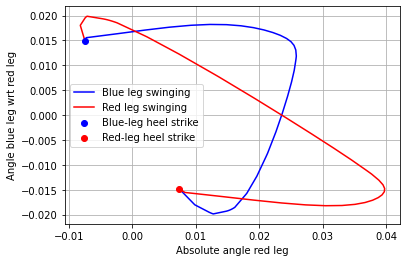

In [125]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], q_opt[:, 3], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3], - q_opt[:, 3], color='r', label='Red leg swinging')

# scatter heel strikes
plt.scatter(q_opt[0, 2] + q_opt[0, 3], - q_opt[0, 3], color='b', zorder=3, label='Blue-leg heel strike')
plt.scatter(q_opt[0, 2], q_opt[0, 3], color='r', zorder=3, label='Red-leg heel strike')

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Angle blue leg wrt red leg')
plt.grid(True)
plt.legend()

Here we plot the absolute angle of the red leg versus its time derivative.
Again we complete the cycle by mirroring the result of the trajectory step.

If you did thing correctly, this figure should resemble [Figure 4.10 from the lecture notes](http://underactuated.mit.edu/simple_legs.html#compass_gait) (with reversed signs).
Note that the angle of the red leg is continuous during the walking cycle, while its time derivative has two jumps.

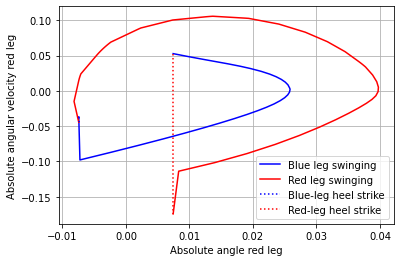

In [126]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], qd_opt[:, 2], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3], qd_opt[:, 2] + qd_opt[:, 3], color='r', label='Red leg swinging')

# plot heel strikes
plt.plot(
    [q_opt[-1, 2], q_opt[0, 2] + q_opt[0, 3]],
    [qd_opt[-1, 2], qd_opt[0, 2] + qd_opt[0, 3]],
    linestyle=':',
    color='b',
    label='Blue-leg heel strike'
)
plt.plot(
    [q_opt[0, 2], q_opt[-1, 2] + q_opt[-1, 3]],
    [qd_opt[0, 2], qd_opt[-1, 2] + qd_opt[-1, 3]],
    linestyle=':',
    color='r',
    label='Red-leg heel strike'
)

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Absolute angular velocity red leg')
plt.grid(True)
plt.legend()